# Classifier
> This is the class that creates the dictionary model

In [ ]:
#| default_exp Classifier

In [ ]:
#| hide
from nbdev.showdoc import *
from matplotlib import pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
#| export
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
#negative_words file
df = pd.read_csv('negative_words(Julio).csv')
df = df.drop(columns=['original']) #drop it since it contains the concept with an * in it

neg_words = [] 
for _, row in df.iterrows():
    for item in row:
        if pd.notnull(item):
            neg_words.append(item.strip())

In [ ]:
#Drop duplicates in neg_words:
neg_words = list(set(neg_words))

len(neg_words)

1599

In [ ]:
#moral_foundations_dictionary file:
df = pd.read_csv('moral_foundations_dictionary(Julio).csv')
df = df[['categories','word_examples']]

virtue = []
vice = []
for _, row in df.iterrows():
    if pd.notnull(row['word_examples']):
        words = row['word_examples'].split(',')
        words = [word.strip() for word in words]
        if 'Virtue' in row['categories']:
            virtue.extend(words)
        elif 'Vice' in row['categories']:
            vice.extend(words)
        else:
            print(words)

['moralidad']
['moral']
['etica']
['etico']
['principios']
['valores']
['bueno', 'buena']
['bondadoso']
['correcto']
['erroneo', 'equivocado', 'incorrecto', 'malo']
['justicia']
['fechoria', 'pecado', 'indebido']
['virtud']
['vicioso']
['moralidad']
['etica']


In [ ]:
virtue.extend(['moralidad','moral','etica','etico','principios','valores','bueno','buena','bondadoso','correcto','justicia','virtud','moralidad','etica'])
vice.extend(['erroneo','equivocado','incorrecto','malo','fechoria','pecado','indebido','vicioso'])
#Drop duplicates in virtue and vice:
virtue = list(set(virtue))
vice = list(set(vice).union(set(neg_words)))


In [ ]:

print('vice examples: ', vice[:10])
print('virtue examples: ', virtue[:10])

print('vice length: ', len(vice))
print('virtue length: ', len(virtue))
print('total words:', len(vice) + len(virtue))

print('vice proportion: ', round(len(vice)/(len(vice) + len(virtue)),2)) 
print('virtue proportion: ', round(len(virtue)/(len(vice) + len(virtue)),2))

vice examples:  ['disgustar', 'reclamar', 'querella', 'estropear', 'duelo', 'alarmado', 'gruño', 'rebajado', 'locos', 'interrumpiésemos']
virtue examples:  ['imparcialidad', 'ordenar', 'beneficiar', 'buena', 'empatico', 'balanceado', 'casta', 'aliados', 'justo', 'cuidar']
vice length:  1691
virtue length:  210
total words: 1901
vice proportion:  0.89
virtue proportion:  0.11


In [ ]:
#eliminate accents from words:
import unidecode
vice = [unidecode.unidecode(word) for word in vice]
virtue = [unidecode.unidecode(word) for word in virtue]



In [ ]:

#replace 'ñ' for 'n':
vice = [word.replace('ñ','n') for word in vice]
virtue = [word.replace('ñ','n') for word in virtue]

In [ ]:
print('vice examples: ', vice[:10])
print('virtue examples: ', virtue[:10])

vice examples:  ['disgustar', 'reclamar', 'querella', 'estropear', 'duelo', 'alarmado', 'gruno', 'rebajado', 'locos', 'interrumpiesemos']
virtue examples:  ['imparcialidad', 'ordenar', 'beneficiar', 'buena', 'empatico', 'balanceado', 'casta', 'aliados', 'justo', 'cuidar']


We have a bigger proportion of vice words which may have an important effect on the tagging task usin KNN

In [ ]:
#Load the embeddings to data frame:
def load_embeddings(file_path):
    word_to_vec = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

word_to_vec = load_embeddings('vectorspol.txt')

In [ ]:
words = vice + virtue
words = set(words)

In [ ]:
#| export
class Classifier:
    def __init__(self):
        self.embeddings = None
        self.vice = None
        self.virtue = None

    def load_embeddings(file_path):
        '''Loads the embeddings from a file and returns a dictionary with the words as keys and the vectors as values'''
        word_to_vec = {}
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                values = line.split()
                word = values[0]
                vector = np.array(values[1:], dtype='float32')
                print(vector.shape)
                word_to_vec[word] = vector
        self.embeddings = word_to_vec
        return word_to_vec
    
    
    def list_to_vec(vice, virtue, word_to_vec):
        '''Returns the vector representation of a list of words in a df'''
        data = {'word': [], 'vector': [], 'category': []}
        for word in vice:
            if word in word_to_vec.keys():
                data['word'].append(word)
                data['vector'].append(word_to_vec[word])
                data['category'].append(0.0) #vice will be represented as 0
            else:
                data['word'].append(word)
                data['vector'].append(np.nan)
                data['category'].append(0.0) 
        
        for word in virtue:
            if word in word_to_vec.keys():
                data['word'].append(word)
                data['vector'].append(word_to_vec[word])
                data['category'].append(1.0) #virtue will be represented as 1
            else:
                data['word'].append(word)
                data['vector'].append(np.nan)
                data['category'].append(1.0)

        df = pd.DataFrame(data)
        return df

In [ ]:
def list_to_vec(vice, virtue, word_to_vec):
    '''Returns the vector representation of a list of words in a df'''
    data = {'word': [], 'vector': [], 'category': []}
    words_notin = []
    for word in vice:
        if word in word_to_vec.keys():
            data['word'].append(word)
            data['vector'].append(word_to_vec[word])
            data['category'].append(0.0) #vice will be represented as 0
        else:
            data['word'].append(word)
            data['vector'].append(np.nan)
            data['category'].append(0.0)
            words_notin.append(word)
    
    for word in virtue:
        if word in word_to_vec.keys():
            data['word'].append(word)
            data['vector'].append(word_to_vec[word])
            data['category'].append(1.0) #virtue will be represented as 1
        else:
            data['word'].append(word)
            data['vector'].append(np.nan)
            data['category'].append(1.0)
            words_notin.append(word)

    df = pd.DataFrame(data)
    return df, words_notin

df,words_notin = list_to_vec(vice,virtue,word_to_vec)
df2= pd.DataFrame()
# Asigna la lista como una nueva columna del DataFrame
df2['words not in embeddings'] = words_notin

total = len(df)
print('Total words: ',total)
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
print('Total words after dropping NaN: ',len(df))
print('∆: ',total-len(df))
print('∆%:', round((total-len(df))/total*100,2) )
df


Total words:  1901
Total words after dropping NaN:  1260
∆:  641
∆%: 33.72


,word,vector,category
0,reclamar,"[0.350479, 0.451604, -0.038733, 0.004833, 0.09...",0.0
1,querella,"[0.372906, 0.212048, 0.07853, 0.396364, 0.2686...",0.0
2,duelo,"[0.03649, -0.714654, 0.320353, 0.369299, -0.34...",0.0
3,alarmado,"[-0.242345, 0.106267, -0.283696, 0.385316, 0.3...",0.0
4,rebajado,"[-0.433806, -0.272883, -0.933484, 0.264673, 0....",0.0
...,...,...,...
1255,reciprocidad,"[0.027735, 0.303429, -0.187403, 0.371294, 0.07...",1.0
1256,blindar,"[0.575569, -0.052739, -0.048362, 0.442083, -0....",1.0
1257,gremio,"[-0.192371, -0.257035, -0.517887, -1.009554, -...",1.0
1258,equitativamente,"[0.04587, 0.226428, -0.237832, 0.400725, -0.36...",1.0


In [ ]:
df2.to_csv('words_notin_embeddings.csv',index=False)

In [ ]:
#write a function to return a boolean if a word is in the embeddings:
def is_in_embeddings(word,word_to_vec):
    '''Returns a boolean if the word is in the embeddings'''
    return word in word_to_vec.keys()

print(is_in_embeddings('lioso',word_to_vec))

False


## Vice words

In [ ]:
df[df['category'] == 0.0]

,word,vector,category
0,gravedad,"[0.406933, -0.442615, 0.150346, 0.196391, 0.46...",0.0
1,reclamar,"[0.350479, 0.451604, -0.038733, 0.004833, 0.09...",0.0
2,querella,"[0.372906, 0.212048, 0.07853, 0.396364, 0.2686...",0.0
3,duelo,"[0.03649, -0.714654, 0.320353, 0.369299, -0.34...",0.0
4,alarmado,"[-0.242345, 0.106267, -0.283696, 0.385316, 0.3...",0.0
...,...,...,...
1064,abandone,"[0.067921, -0.367901, -0.07643, 0.076776, 0.25...",0.0
1065,devastacion,"[-0.623626, -0.312241, -0.085955, 0.00901, -0....",0.0
1066,llorando,"[0.225656, 0.076165, -0.011752, 0.036493, -0.5...",0.0
1067,excluyente,"[0.029632, -0.521416, 0.069739, 0.01097, 0.114...",0.0


## Virtue words

In [ ]:
df[df['category'] == 1.0].reset_index(drop=True)

,word,vector,category
0,imparcialidad,"[-0.271824, -0.125822, 0.096738, 0.458268, 0.6...",1.0
1,ordenar,"[0.967317, 0.239572, -0.26908, -0.046095, 0.03...",1.0
2,beneficiar,"[0.386634, 0.620873, -0.233254, 0.273299, -0.1...",1.0
3,buena,"[-0.225948, -0.338355, 0.192, 0.190509, -0.138...",1.0
4,empatico,"[-0.273632, -0.032786, -0.114944, 0.601547, -0...",1.0
...,...,...,...
186,reciprocidad,"[0.027735, 0.303429, -0.187403, 0.371294, 0.07...",1.0
187,blindar,"[0.575569, -0.052739, -0.048362, 0.442083, -0....",1.0
188,gremio,"[-0.192371, -0.257035, -0.517887, -1.009554, -...",1.0
189,equitativamente,"[0.04587, 0.226428, -0.237832, 0.400725, -0.36...",1.0


In [ ]:
X = np.array(df['vector'].tolist())
print(X)
y = np.array(df['category'].tolist())
print(y)

[[ 0.406933 -0.442615  0.150346 ...  0.163208  0.050834  0.061015]
 [ 0.350479  0.451604 -0.038733 ... -0.160872  0.151122  0.226422]
 [ 0.372906  0.212048  0.07853  ...  0.894929  0.401156  0.726543]
 ...
 [-0.192371 -0.257035 -0.517887 ...  0.547242  0.286338 -0.057461]
 [ 0.04587   0.226428 -0.237832 ...  0.661773  0.514155 -0.623272]
 [-0.448656  1.283608 -0.08672  ...  0.547518  0.155616  0.122199]]
[0. 0. 0. ... 1. 1. 1.]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['vector'], df['category'], test_size=0.2, random_state=21,stratify=df['category'])
X_train = X_train.to_list()
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
X_test = X_test.to_list()
print(round(knn.score(X_test, y_test),3))

0.913


/Users/gerardoguerrero/anaconda3/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


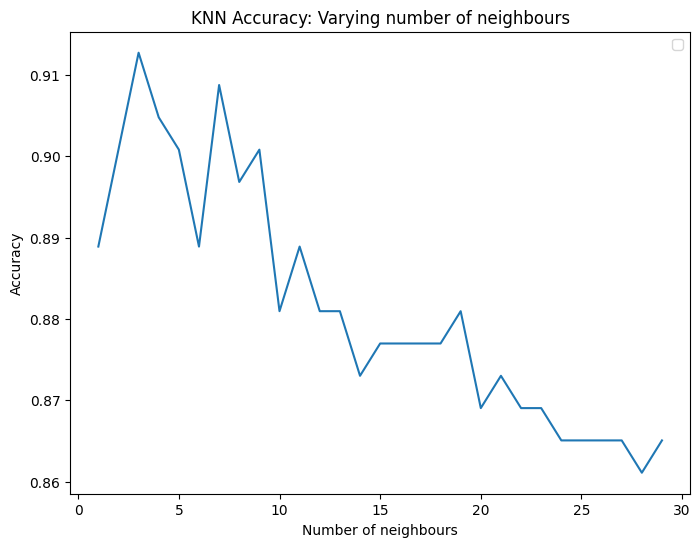

Best accuracy and number of neighbours:  (3, 0.9126984126984127)


In [ ]:
test_accuracies = {}
neighbours = range(1, 30)

for neighbour in neighbours:
    knn = KNeighborsClassifier(n_neighbors=neighbour)
    knn.fit(X_train, y_train)
    test_accuracies[neighbour] = knn.score(X_test, y_test)
    
plt.figure(figsize=(8,6))
plt.title('KNN Accuracy: Varying number of neighbours')
plt.plot(list(test_accuracies.keys()), list(test_accuracies.values()))
plt.legend()
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')
plt.show()

print('Best accuracy and number of neighbours: ', max(test_accuracies.items(), key=lambda x: x[1]))

### Using the model to tag adjectives found on media*
> Issues to be solved...

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)


KNeighborsClassifier()

In [ ]:
#Adjs found in comments using spaCy library:
adjs = set()
with open('adjs_comments.txt', 'r', encoding='utf-8') as file:
    for line in file:
        adjs.add(line.strip())

adjs = list(adjs)
print(adjs[:10])
print(len(adjs))

['chayoteros', 'familiares', 'fraudes', 'tranquilo', 'sanganos', 'locos', 'pesado', 'verdaderos', 'lne', 'asecino']
1642


In [ ]:
print('justo' in words)

True


In [ ]:
#Adjs from comments but not in words:
adjs_set = set(adjs)
diference = adjs_set.difference(words)
print(len(diference))
print(diference)

1522
{'chayoteros', 'familiares', 'fraudes', 'tranquilo', 'sanganos', 'verdaderos', 'lne', 'asecino', 'ponte', 'ranas', 'encabezado', 'malditas', 'stos', 'mera', 'demas', 'oportunistas', 'visto', 'entero', 'prometido', 'amargadas', 'manche', 'aburre', 'celular', 'muertas', 'acompano', 'simulada', 'innecesaio', 'coructos', 'anti', 'raterossalta', 'social', 'hocicon', 'equivocas', 'america', 'empresariales', 'conchudos', 'honrosas', 'agancaso', 'energetica', 'comercial', 'carreados', 'maravilloso', 'acarrados', 'transparente', 'ridiculos', 'pintada', 'enfermos', 'rata', 'gorda', 'extranjeros', 'dios', 'comprada', 'desonesto', 'ardidos', 'sintetica', 'afectados', 'senora', 'mexicanos', 'sano', 'ofenza', 'relajate', 'antimexicanos', 'mantenidoscorruptos', 'prostitutos', 'mexico', 'cansados', 'chentito', 'primero', 'beneficiados', 'borregada', 'gatos', 'arrabaleros', 'queridos', 'envidiosote', 'k', 'aprovechados', 'corrompido', 'fertilizante', 'delicuentes', 'perros', 'vendidas', 'hambrient

In [ ]:
print('justo' in diference)

False


In [ ]:
adj_tag = {}
for adj in adjs:
    if adj in word_to_vec.keys():
        tag = knn.predict([word_to_vec[adj]])
        adj_tag[adj] = tag[0]
        
print(list(adj_tag.items())[:100])

df3 = pd.DataFrame(list(adj_tag.items()), columns=['adjective', 'category'])
df3.sort_values(by='category',inplace=True)
df3.reset_index(drop=True,inplace=True)
df3.to_csv('predicted_tag.csv',index=False)


[('familiares', 0.0), ('fraudes', 0.0), ('tranquilo', 0.0), ('locos', 0.0), ('pesado', 0.0), ('verdaderos', 0.0), ('ponte', 1.0), ('ranas', 0.0), ('encabezado', 1.0), ('malditas', 0.0), ('mera', 0.0), ('demas', 0.0), ('podrido', 0.0), ('oportunistas', 0.0), ('visto', 0.0), ('entero', 0.0), ('prometido', 0.0), ('manche', 0.0), ('aburre', 0.0), ('muertas', 0.0), ('acompano', 0.0), ('celular', 0.0), ('simulada', 0.0), ('anti', 0.0), ('social', 1.0), ('america', 1.0), ('empresariales', 1.0), ('energetica', 0.0), ('comercial', 0.0), ('maravilloso', 0.0), ('transparente', 1.0), ('ridiculos', 0.0), ('pintada', 1.0), ('enfermos', 0.0), ('rata', 0.0), ('gorda', 0.0), ('extranjeros', 0.0), ('dios', 0.0), ('comprada', 0.0), ('sintetica', 0.0), ('afectados', 0.0), ('senora', 1.0), ('mexicanos', 0.0), ('sano', 0.0), ('mexico', 0.0), ('cansados', 0.0), ('primero', 1.0), ('beneficiados', 0.0), ('gatos', 0.0), ('queridos', 0.0), ('k', 0.0), ('aprovechados', 0.0), ('corrompido', 0.0), ('fertilizante', 

## Confussion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix



## Given a word, return the k nearest neighbors:

In [ ]:
def get_k_nearest_neighbours(word, k, word_to_vec,knn):
    '''Given a word, return the k nearest neighbours'''
    if word in word_to_vec.keys():
        word_vec = [word_to_vec[word]]
        results = knn.kneighbors(word_vec, n_neighbors=k, return_distance=True)
        index = results[1]
        for i in index:
            print(df.iloc[i]['word'])
    else:
        print('The word is not in the vocabulary')
        
get_k_nearest_neighbours('excelente', 3, word_to_vec,knn)

1072       buena
193     teniendo
196        pesar
Name: word, dtype: object


## Given a word, predict its category

In [ ]:
def predict_category(word, word_to_vec, knn):
    if word in word_to_vec.keys():
        word_vec = [word_to_vec[word]]
        tag = knn.predict(word_vec)
        if tag[0] == 0.0:
            print('The word is a vice')
        else:
            print('The word is a virtue')
    else:
        print('The word is not in the vocabulary')

predict_category('excelente', word_to_vec, knn)

The word is a vice
